# Pytorch Deep Neural Network V5
## Analysis of Gregor Dataset (Top Tagging)

## Uses preprocessed data

### 4 hidden layer NN
### Has real time plotting of training

## Started June, 6 2019
### Genevieve Hayes


In [90]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import seaborn as sb
import matplotlib.pylab as plt
#import matplotlib as mpl
import h5py
import tables
import math
import time
import sklearn.metrics as sklm

In [91]:
run_gpu=False
if run_gpu:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

In [92]:
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split

# Training dataset loading class
class TrainDataset(Dataset):
    # Initialize our data, download, etc.  
    def __init__(self):
        #read pickle file
        df_train = pd.read_pickle("train.pkl")
        
        #numpy representation of DataFrame
        array_train = df_train.values
        
        self.len = array_train.shape[0]
        self.width = array_train.shape[1]
        self.x_data = torch.from_numpy(array_train[:,0:90]).float() #x data is only the 4 vectors of the constituents   
        self.y_data = torch.from_numpy(array_train[:,-1]).long() #y data is only the labels (0=QCD, 1=top)
        self.rawY_data = torch.from_numpy(array_train[:,-2]).long()
        self.weight = torch.from_numpy(array_train[:,0]).float()
        
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    
    def __len__(self):
        return self.len
    
# Validation dataset loading class
class ValDataset(Dataset):
    # Initialize our data, download, etc.
    def __init__(self):
        #read pickle file
        df_val = pd.read_pickle("val.pkl")
        
        #numpy representation of DataFrame
        array_val = df_val.values
        
        self.len = array_val.shape[0]
        self.width = array_val.shape[1]
        self.x_data = torch.from_numpy(array_val[:,0:90]).float()
        self.y_data = torch.from_numpy(array_val[:,-1]).long()
        self.rawY_data = torch.from_numpy(array_val[:,-2]).long()
        self.weight = torch.from_numpy(array_val[:,0]).float()
        
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    
    def __len__(self):
        return self.len

In [93]:
########################
# Load Preprocessed Data
########################
training_dataset = TrainDataset()
validation_dataset = ValDataset()

train_len = training_dataset.len
train_width = training_dataset.width
val_len = validation_dataset.len
val_width = validation_dataset.width

## Net Structure 

In [150]:
################################################
#Creating Network Structure class in PyTorch way
################################################
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #Input layer is 30 constituents each with 3 features
        self.linear1 = nn.Linear(90,300) #4 hidden layers
        self.linear2 = nn.Linear(300,102)
        self.linear3 = nn.Linear(102,12)    
        self.linear4 = nn.Linear(12,6)
        self.linear5 = nn.Linear(6,2)  #1 output (top or qcd)
        
    def forward(self, x):
#        x = x.view(,-1) #Flatten the data
        out1 = F.relu(self.linear1(x))
        out2 = F.relu(self.linear2(out1))
        out3 = F.relu(self.linear3(out2))
        out4 = F.relu(self.linear4(out3))
        #y_pred = F.softmax(self.linear5(out4),1) #softmax activation function
        y_pred = torch.sigmoid(self.linear5(out4)) #sigmoid activation function
        #y_preds.size() --> 5000, 2
        return y_pred
model = Net()

## Construct Loss and Optimizer

In [182]:
num_epochs = 3
batch_len = 5000
learning_rate = 0.001

In [183]:
######################
#Loss and optimization
######################
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5) #Stochastic Gradient Descent with momentum
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #ADAM optimizer

In [184]:
######################
#Make Dataloaders
######################
training_loader = DataLoader(dataset=training_dataset, batch_size=batch_len, shuffle=True, num_workers=2)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_len, shuffle=False, num_workers=2)

In [185]:
final_out = []
for i, data in enumerate(training_loader, 0):
        ### 1. get the inputs ###
        inputs,labels=data
        
        ### 2. wrap them in Variable ###
        inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Forward pass: Compute predicted y by passing x to the model
        outputs=model(inputs)
        preds=torch.max(outputs.data,1)[1]
        
        final_out.extend(preds)
        #preds has size [batch_size]
        
#check size and shape of labels, inputs, outputs

#print(labels.shape)    #= torch.Size([500])
#print(inputs.shape)    #= torch.Size([500, 800])
#print(outputs.shape)   #= torch.Size([500, 2])

In [186]:
print(len(training_dataset))
print(len(outputs))
print(len(final_out))


1211000
1000
1211000


## Train the neural network

Epoch 0/2
--
Training Accuracy:0.9203
Validation Accuracy:0.9079 



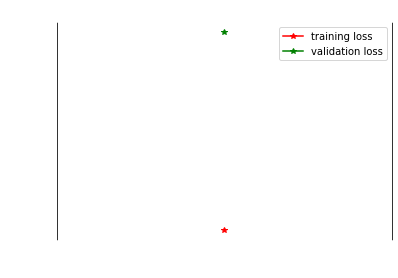

Epoch 1/2
--
Training Accuracy:0.9212
Validation Accuracy:0.9083 

Epoch 2/2
--
Training Accuracy:0.9221
Validation Accuracy:0.9085 



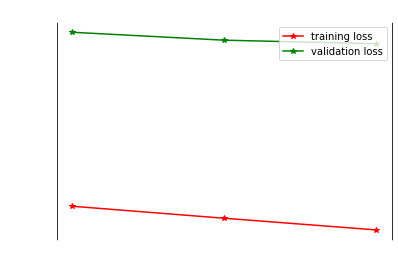

--- 59.04626107215881 seconds ---
--- 0 min and 60 sec ---


In [225]:
#########
#Training
#########
start_time = time.time()

training_loss_list=[]
validation_loss_list=[]
training_acc_list=[]
validation_acc_list = []


for epoch in range(num_epochs):
#Training cycle (forward, backward, update)
    if (epoch%1==0 or epoch==num_epochs - 1):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 2)
        
    model.train()
    train_loss = 0.0
    train_corrects = 0
    
    for i, data in enumerate(training_loader, 0):
        
        ### 1. get the inputs ###
        inputs,labels=data
        
        ### 2. wrap them in Variable ###
        inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        
        
        #Forward pass: Compute predicted y by passing x to the model
        outputs=model(inputs)
        preds=torch.max(outputs.data,1)[1]
        
        #print(labels.size())
        #print(outputs.size())
        
        #outputs = outputs[:,0]
        #print(labels.size())
        #print(outputs.size())
        
        #Compute loss
        loss=criterion(outputs,labels)
        
        #Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*inputs.size(0)
        
        #extract TP+TN
        train_corrects += torch.sum(preds == labels.data)
        
    epocht_loss = train_loss/train_len
    epocht_acc = train_corrects.double()/train_len
    
    training_loss_list.append(epocht_loss)
    training_acc_list.append(epocht_acc)
    
    #Visualization
    print('Training Accuracy:{:.4f}'.format(epocht_acc))
    if (epoch%2==0 or epoch==num_epochs - 1):
    
        counter = range(epoch+1)
        figtrain = plt.figure()
        axtrain = figtrain.add_subplot(111)
        plt.plot(counter,training_loss_list,'-*r',linestyle = 'solid',label="training loss")
#Validation cycle (forward, save)
    model.eval()
    val_loss=0
    val_corrects=0
    final_output = []
    final_preds = []
    
    with torch.no_grad():
        for data in validation_loader:
            inputs,labels=data
            inputs,labels = Variable(inputs), Variable(labels)
            outputs = model(inputs)
            #sum up batch loss
            loss = criterion(outputs,labels)
            #get the index of the max log-probability
            preds=torch.max(outputs.data,1)[1]
            val_loss += loss.item()*inputs.size(0)
            
            #extract TP+TN
            val_corrects += torch.sum(preds == labels.data)
            
            final_preds.extend(preds.data.numpy())
            final_output.extend(outputs[:,1].data.numpy())
        
        epoch_loss = val_loss / val_len
        epoch_acc = val_corrects.double() / val_len
        
        validation_loss_list.append(epoch_loss)
        validation_acc_list.append(epoch_acc)

        #Visualization
        print('Validation Accuracy:{:.4f} \n'.format(epoch_acc))
        if (epoch%2==0 or epoch==num_epochs - 1):
            counter = range(epoch+1)
            plt.plot(counter,validation_loss_list,'-*g',linestyle = 'solid',label="validation loss")
        
            plt.title('Loss as a function of epoch',color='w')
            plt.xlabel('Epoch',color='w')
            plt.ylabel('Loss',color='w')
            axtrain.spines['bottom'].set_color('white')
            axtrain.spines['top'].set_color('white')
            axtrain.tick_params(axis='x', colors='white')
            axtrain.tick_params(axis='y', colors='white')
            plt.legend(loc='upper right')
            plt.show()
  
end_time = time.time()   
print("--- {} seconds ---".format(end_time-start_time)) 
print("--- {} min and {} sec ---".format(math.floor((end_time-start_time)/60),math.ceil((end_time-start_time)%60)))

## Evaluate model

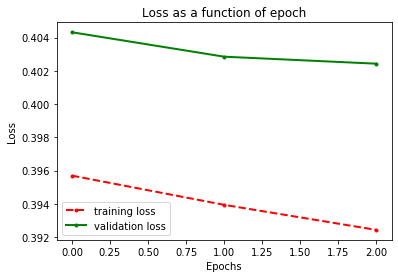

-----3 epochs-----
 
Validation Accuracy: 0.9189
Validation Accuracy:0.9080


In [219]:
x=range(num_epochs)
y_train=training_loss_list
y_val = validation_loss_list
#y_test=testing_loss_list

fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(x,y_train,marker='o',markersize=3,linewidth=2,linestyle='dashed',color='r',label="training loss")
plt.plot(x,y_val,marker='o',markersize=3,linewidth=2,linestyle = 'solid', color='g',label="validation loss")
#plt.plot(x,y_test,marker='o',markersize=3,linewidth=2,linestyle='dashed',color='b',label="test loss")
plt.title('Loss as a function of epoch')#,color='w')


#ax1.spines['bottom'].set_color('white')
#ax1.spines['top'].set_color('white')
#ax1.xaxis.label.set_color('white')
#ax1.yaxis.label.set_color('white')
#ax1.tick_params(axis='x', colors='white')
#ax1.tick_params(axis='y', colors='white')

ax1.set_xlabel('Epochs')#, color='white')
ax1.set_ylabel('Loss')#, color='white')

plt.legend(loc='upper right')
plt.legend()
plt.show()

print('-----{:d} epochs-----\n \nValidation Accuracy: {:.4f}'.format(num_epochs,training_acc_list[-1]))
print('Validation Accuracy:{:.4f}'.format(validation_acc_list[-1]))#epocht_acc))

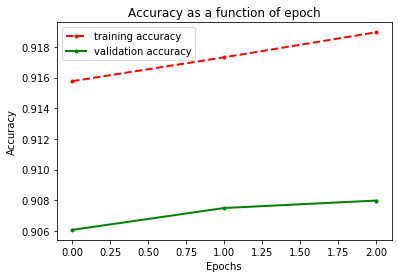

In [220]:
x=range(num_epochs)
y_train=training_acc_list
y_val = validation_acc_list
#y_test=testing_acc_list

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)

plt.plot(x,y_train,marker='o',markersize=3,linewidth=2,linestyle='dashed',color='r',label="training accuracy")
plt.plot(x,y_val,marker='o',markersize=3,linewidth=2,linestyle = 'solid', color='g',label="validation accuracy")
#plt.plot(x,y_test,marker='o',markersize=3,linewidth=2,linestyle='dashed',color='b',label="test accuracy")
plt.title('Accuracy as a function of epoch')#,color='w')

#ax2.spines['bottom'].set_color('white')
#ax2.spines['top'].set_color('white')
#ax2.xaxis.label.set_color('white')
#ax2.yaxis.label.set_color('white')
#ax2.tick_params(axis='x', colors='white')
#ax2.tick_params(axis='y', colors='white')

ax2.set_xlabel('Epochs')#, color='white')
ax2.set_ylabel('Accuracy')#, color='white')

plt.legend(loc='upper right')
plt.legend()
plt.show()

# Confusion Matrix

In [222]:
#validation_confusion_matrix = sklm.confusion_matrix(labels.data,preds)
#tn, fp, fn, tp = sklm.confusion_matrix(labels.data,preds).ravel()

validation_confusion_matrix = sklm.confusion_matrix(validation_dataset.y_data,final_output)
tn, fp, fn, tp = sklm.confusion_matrix(validation_dataset.y_data,final_output).ravel()

print('TN = {}, FP = {}, FN = {}, TP = {}\n'.format(tn, fp, fn, tp))
print('Confusion matrix of validation data:\n',validation_confusion_matrix)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

# Precision, Recall and F-measure

In [192]:
precision = sklm.precision_score(validation_dataset.y_data,final_output)
#print('Precision: {:.4f}'.format(precision))
recall = sklm.recall_score(validation_dataset.y_data,final_output)
#print('Recall: {:.4f}'.format(recall))
f1 = sklm.f1_score(validation_dataset.y_data,final_output)
#print('F1: {:.4f}'.format(f1))

from IPython.display import HTML, display
import tabulate
table = [["Precision","{:.3f}".format(precision)],
         ["Recall","{:.3f}".format(recall)],
         ["F1","{:.3f}".format(f1)]]
        
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Precision,0.866
Recall,0.956
F1,0.909


# ROC Curve and AUC

In [226]:
#plt.hist(outputs.data[:,0])
#plt.hist(final_output)
#plt.hist(preds.data[:])
#print(preds.shape)
#print(outputs.data)

#print(len(outputs.data))
#print(len(final_output))
#print(len(validation_dataset.y_data))

print(np.array(final_output[0:20]))
print(np.transpose(validation_dataset.y_data[0:20].numpy()))



[4.1560284e-39 8.4644243e-11 1.1523666e-10 4.1560284e-39 4.1560284e-39
 5.6000136e-02 1.4329881e-12 4.1560284e-39 4.1560284e-39 9.9999845e-01
 1.0000000e+00 9.9999690e-01 1.0000000e+00 1.0000000e+00 9.9999619e-01
 9.9998033e-01 1.0000000e+00 9.1377407e-01 1.0000000e+00 9.9999785e-01]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [105]:
fpr, tpr, thresholds = sklm.roc_curve(labels.data,outputs.data[:,1],pos_label=None)

40658 40658 40658
AUC: 0.9596


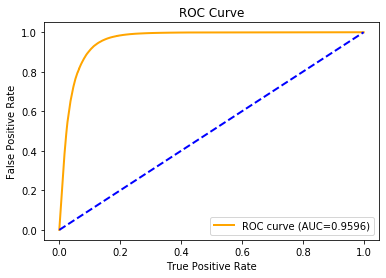

In [227]:
# fpr, tpr, thresholds = sklm.roc_curve(labels.data,outputs.data[:,1],pos_label=None)
# auc = sklm.roc_auc_score(labels.data,outputs.data[:,1])



fpr, tpr, thresholds = sklm.roc_curve(validation_dataset.y_data.numpy(),np.array(final_output),pos_label=1)
auc = sklm.roc_auc_score(validation_dataset.y_data.numpy(),np.array(final_output))
print(len(fpr),len(tpr),len(thresholds))

print('AUC: {:.4f}'.format(auc))


#ROC curve
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111)

#plt.plot(fpr,tpr)
plt.plot(fpr,tpr,linewidth=2,linestyle='solid',color='orange',label="ROC curve (AUC={:.4f})".format(auc))
plt.plot(fpr,fpr,linewidth=2,linestyle='dashed',color='b')
plt.title('ROC Curve')#,color='w')

# ax3.spines['bottom'].set_color('white')
# ax3.spines['top'].set_color('white')
# ax3.xaxis.label.set_color('white')
# ax3.yaxis.label.set_color('white')
# ax3.tick_params(axis='x', colors='white')
# ax3.tick_params(axis='y', colors='white')

ax3.set_xlabel('True Positive Rate')#, color='white')
ax3.set_ylabel('False Positive Rate')#, color='white')

plt.legend(loc='lower right')
plt.legend()
plt.show()

In [107]:
# THIS IS STILL NOT IDEAL
#to catch divisions by zero

def safe_div(x,y):
    division = np.empty(np.size(y))
    for idx in range(np.size(y)):
        if y[idx] == 0:
            division[idx] = x / 0.00001
        else:
            division[idx] = x / y[idx]       
    return division

background_rejection = safe_div(1,fpr)

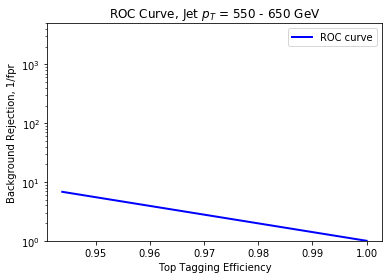

0.0


In [167]:
background_rejection = safe_div(1,fpr)
#background_rejection = 1/fpr[2:] #the first and second elements of fpr are usually zero, so disregard these to avoid divide by zero

#ROC curve (using background rejection)
fig4 = plt.figure(4)
ax4 = fig4.add_subplot(111)

#plt.plot(fpr,tpr)
plt.semilogy(tpr[1:],background_rejection[1:],linewidth=2,linestyle='solid',color='blue',label="ROC curve")
#plt.plot(background_rejection,background_rejection,linewidth=2,linestyle='dashed',color='b')
plt.title('ROC Curve, Jet $p_T$ = 550 - 650 GeV')#,color='w')

# ax4.spines['bottom'].set_color('white')
# ax4.spines['top'].set_color('white')
# ax4.xaxis.label.set_color('white')
# ax4.yaxis.label.set_color('white')
# ax4.tick_params(axis='x', colors='white')
# ax4.tick_params(axis='y', colors='white')

ax4.set_xlabel('Top Tagging Efficiency')#, color='white')
ax4.set_ylabel('Background Rejection, 1/fpr')#, color='white')

plt.ylim(1, 5000)

plt.legend(loc='upper right')
plt.legend()
plt.show()

print(fpr[0])

In [25]:
#indexing function to find % signal efficiency

def find_nearest_ind(array,value):
    array = np.asarray(array)
    ind = (np.abs(array-value)).argmin()
    return ind, array[ind]

In [26]:
#looking for 50% signal efficiency
index_20,signal_efficiency_20 =find_nearest_ind(tpr,0.2)
index_50,signal_efficiency_50 =find_nearest_ind(tpr,0.5)
index_80,signal_efficiency_80 =find_nearest_ind(tpr,0.8)

#print('Background rejection at {:.1f}% signal efficiency: {:.3}\n'.format(signal_efficiency_20*100,background_rejection[index_20]))
#print('Background rejection at {:.1f}% signal efficiency: {:.3}\n'.format(signal_efficiency_50*100,background_rejection[index_50]))
#print('Background rejection at {:.1f}% signal efficiency: {:.3}\n'.format(signal_efficiency_80*100,background_rejection[index_80]))

from IPython.display import HTML, display
import tabulate
table = [["Signal Efficiency","Background Rejection"],
         ["{:.1f}".format(signal_efficiency_20*100),"{:.2f}".format(background_rejection[index_20])],
         ["{:.1f}".format(signal_efficiency_50*100),"{:.2f}".format(background_rejection[index_50])],
         ["{:.1f}".format(signal_efficiency_80*100),"{:.2f}".format(background_rejection[index_80])]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Signal Efficiency,Background Rejection
0.0,100000.00
83.3,7.00
83.3,7.00


In [27]:
#Would like a DNN distribution for the signal and background samples (probability density as a function of neural network output)
#plt.plot(outputs.data[:,1])
#print(outputs.data[:,1])

# Results: Testing the Neural Network

In [240]:
###############################
#Testing dataset loading class
##############################
class TestDataset(Dataset):
    # Initialize our data, download, etc.
    def __init__(self):
        #read pickle file
        df_test = pd.read_pickle("test.pkl")
        
        #numpy representation of DataFrame
        array_test = df_test.values
        
        self.len = array_test.shape[0]
        self.width = array_test.shape[1]
        self.x_data = torch.from_numpy(array_test[:,0:90]).float()
        self.y_data = torch.from_numpy(array_test[:,-1]).long()
        #self.rawY_data = torch.from_numpy(array_test[:,-2]).long()
        #self.weight = torch.from_numpy(array_test[:,0]).float()
        
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]#,self.weight[index],self.rawY_data[index]
    
    def __len__(self):
        return self.len

In [241]:
###############
#Load test data
###############
testing_dataset = TestDataset()
test_len = testing_dataset.len

t_batch_size = 1000
#make dataloader
testing_loader = DataLoader(dataset=testing_dataset, batch_size=t_batch_size, shuffle=False, num_workers=2)

In [256]:
#########
#Testing
########
start_time = time.time()

model.eval()
test_loss=0
test_corrects=0
final_test_outputs = []
final_test_preds = []
    
with torch.no_grad():
    for data in testing_loader:
        inputs,labels=data
        inputs,labels = Variable(inputs), Variable(labels)
        test_outputs = model(inputs)
        #sum up batch loss
        loss = criterion(test_outputs,labels)
        #get the index of the max log-probability
        test_preds=torch.max(test_outputs.data,1)[1]
        test_loss += loss.item()*inputs.size(0)

        #extract TP+TN
        test_corrects += torch.sum(test_preds == labels.data)

        final_test_preds.extend(test_preds.data.numpy())
        final_test_outputs.extend(test_outputs[:,1].data.numpy())
        #print(len(final_test_outputs),len(final_test_preds), len(labels))

    final_test_loss_test = test_loss / test_len
    final_test_acc = test_corrects.double() / test_len

    print('Accuracy:{:.4f} \n'.format(final_test_acc))

end_time = time.time()   
print("--- {:.4f} seconds ---".format(end_time-start_time)) 
print("--- {} min and {} sec ---".format(math.floor((end_time-start_time)/60),math.ceil((end_time-start_time)%60)))

Accuracy:0.9096 

--- 2.0680 seconds ---
--- 0 min and 3 sec ---


40909 40909 40909
AUC: 0.9601


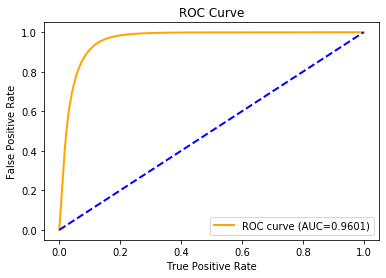

In [248]:
##########
#ROC curve
##########
predicted = np.array(final_test_outputs)
truth = testing_dataset.y_data.numpy()


fpr, tpr, thresholds = sklm.roc_curve(truth,predicted,pos_label=1)
auc = sklm.roc_auc_score(truth,predicted)
print(len(fpr),len(tpr),len(thresholds))

print('AUC: {:.4f}'.format(auc))

#ROC curve
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111)

#plt.plot(fpr,tpr)
plt.plot(fpr,tpr,linewidth=2,linestyle='solid',color='orange',label="ROC curve (AUC={:.4f})".format(auc))
plt.plot(fpr,fpr,linewidth=2,linestyle='dashed',color='b')
plt.title('ROC Curve')

ax3.set_xlabel('True Positive Rate')
ax3.set_ylabel('False Positive Rate')

plt.legend(loc='lower right')
plt.legend()
plt.show()

In [112]:
test_fpr, test_tpr, test_thresholds = sklm.roc_curve(test_labels.data,test_outputs.data[:,1],pos_label=None)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [113]:
print(len(test_outputs.data[:,1]))
print(len(test_labels.data))
print(len(pred_list))
print(len(test_prediction))
print(len(test_prediction_list))
#rawLabels.numpy()[:]==1
print(len(rawLabels))
print(pred_list[1])
print(test_outputs[1])
print(len(testing_loader))
print(len(testing_dataset))

32
32
32
0
0
32
1.3017409e-11
tensor([2.7790e-10, 1.0000e+00])
4209
404000


In [42]:
# from sklearn.metrics import accuracy_score
# def roc_auc_score_FIXED(y_true, y_pred):
#     if len(np.unique(y_true)) == 1: # bug in roc_auc_score
#         return accuracy_score(y_true, np.rint(y_pred))
#     return roc_auc_score(y_true, y_pred)

# fpr, tpr, thresholds = sklm.roc_curve(labels.data,outputs.data[:,1],pos_label=None)
# auc = sklm.roc_auc_score(labels.data,outputs.data[:,1])

# print('AUC: {:.4f}'.format(auc))
# #ROC curve
# fig3 = plt.figure(3)
# ax3 = fig3.add_subplot(111)

# #plt.plot(fpr,tpr)
# plt.plot(fpr,tpr,linewidth=2,linestyle='solid',color='orange',label="ROC curve (AUC={:.4f})".format(auc))
# plt.plot(fpr,fpr,linewidth=2,linestyle='dashed',color='b')
# plt.title('ROC Curve')#,color='w')

# # ax3.spines['bottom'].set_color('white')
# # ax3.spines['top'].set_color('white')
# # ax3.xaxis.label.set_color('white')
# # ax3.yaxis.label.set_color('white')
# # ax3.tick_params(axis='x', colors='white')
# # ax3.tick_params(axis='y', colors='white')

# ax3.set_xlabel('True Positive Rate')#, color='white')
# ax3.set_ylabel('False Positive Rate')#, color='white')

# plt.legend(loc='lower right')
# plt.legend()
# plt.show()

In [114]:
test_fpr, test_tpr, test_thresholds = sklm.roc_curve(test_labels.data,test_outputs.data[:,1],pos_label=None)
#auc = roc_auc_score_FIXED(test_labels.data,test_outputs.data[:,1])
auc = sklm.roc_auc_score(test_labels.data,test_outputs.data[:,1])

#auc = sklm.roc_auc_score(test_labels.data,test_outputs.data[:,1])

print('AUC: {:.4f}'.format(auc))

#ROC curve
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111)

#plt.plot(fpr,tpr)
plt.plot(test_fpr,test_tpr,linewidth=2,linestyle='solid',color='orange',label="ROC curve (AUC={:.4f})".format(auc))
plt.plot(test_fpr,test_fpr,linewidth=2,linestyle='dashed',color='b')
plt.title('ROC Curve')

ax3.set_xlabel('True Positive Rate')#, color='white')
ax3.set_ylabel('False Positive Rate')#, color='white')

plt.legend(loc='lower right')
plt.legend()
plt.show()

print(test_fpr[3])
print(test_tpr[3])
print(test_thresholds[3])

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

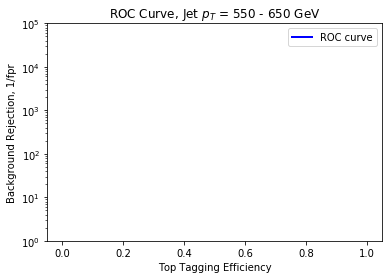

nan


In [249]:
test_background_rejection = 1.0/test_fpr
#background_rejection = 1/fpr[2:] #the first and second elements of fpr are usually zero, so disregard these to avoid divide by zero

#ROC curve (using background rejection)
fig4 = plt.figure(4)
ax4 = fig4.add_subplot(111)

plt.semilogy(test_tpr,test_background_rejection,linewidth=2,linestyle='solid',color='blue',label="ROC curve")
plt.title('ROC Curve, Jet $p_T$ = 550 - 650 GeV')#,color='w')
ax4.set_xlabel('Top Tagging Efficiency')#, color='white')
ax4.set_ylabel('Background Rejection, 1/fpr')#, color='white')

plt.ylim(1, 1e5)

plt.legend(loc='upper right')
plt.legend()
plt.show()

print(test_fpr[0])